In [3]:
import sys
sys.path.append('../datasets')

import torch
import hyde 

import matplotlib.pyplot as plt

from datasets import HSIDataset
from torchvision import transforms
from math import sqrt

In [38]:
# Define device (default is "cpu")
device = "cuda" 

# Define dtype
dtype = torch.float32

# Define random seed
seed = 42
torch.manual_seed(seed)

# Define data path
data_path = '/home/y/Documents/Data/HSI/hyspecnet-11k/datasets/hyspecnet-11k.zarr'

In [39]:
# Loads ENMAP Hypecnet Datasets 
val_transform = transforms.Compose([transforms.ToTensor()]) # Transforms a the input data to torch tensors
dataset = HSIDataset(root_dir=data_path, split='test', transform=val_transform)

# Choose the index of the selected image in the dataset (ENMAP dataset contains 11 000 images)
idx = 1131 
x = dataset[idx].unsqueeze(0).to(device=device,dtype=dtype) # import image to device (cpu or gpu), sizes of x is [1,number of bands, width, height]
# Adds a small amount of white gaussian noise to the input HSI (sigma2 = 1e-4)
x += 1e-2*torch.rand_like(x, device=device, dtype=dtype)

# Adds noise to the input HSI
sigma2 = 0.001
y = x + sqrt(sigma2)*torch.randn_like(x, device=device, dtype=dtype)

In [40]:
## FastHyDe method with a BM3D denoiser
method = hyde.FastHyDe()
output_hyde = method(y.squeeze(0).permute(1,2,0), noise_type="additive", iid=True, k_subspace=10, normalize=True)
output_hyde = output_hyde.permute(2,0,1).unsqueeze(0)


In [60]:
## Using a pretrained model


path_to_model = '..//algorithms/HyDe/pretrained-models/qrnn3d/hyde-bs16-blindSNR-gaussian-qrnn3d-l2.pth'
method = hyde.NNInference(arch="qrnn3d", pretrained_file=path_to_model)
output_qrnn3D = method(y.unsqueeze(0), band_dim=1, permute=False).squeeze(0)


2024-09-26 17:05 - [ HyDe ][ INFO ] Loading model from: ..//algorithms/HyDe/pretrained-models/qrnn3d/hyde-bs16-blindSNR-gaussian-qrnn3d-l2.pth 	 (call_nn_inference.py:21)


/home/y/.pyenv/versions/base-3.8.8/lib/python3.8/site-packages/hyde/nn/call_nn_inference.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrai

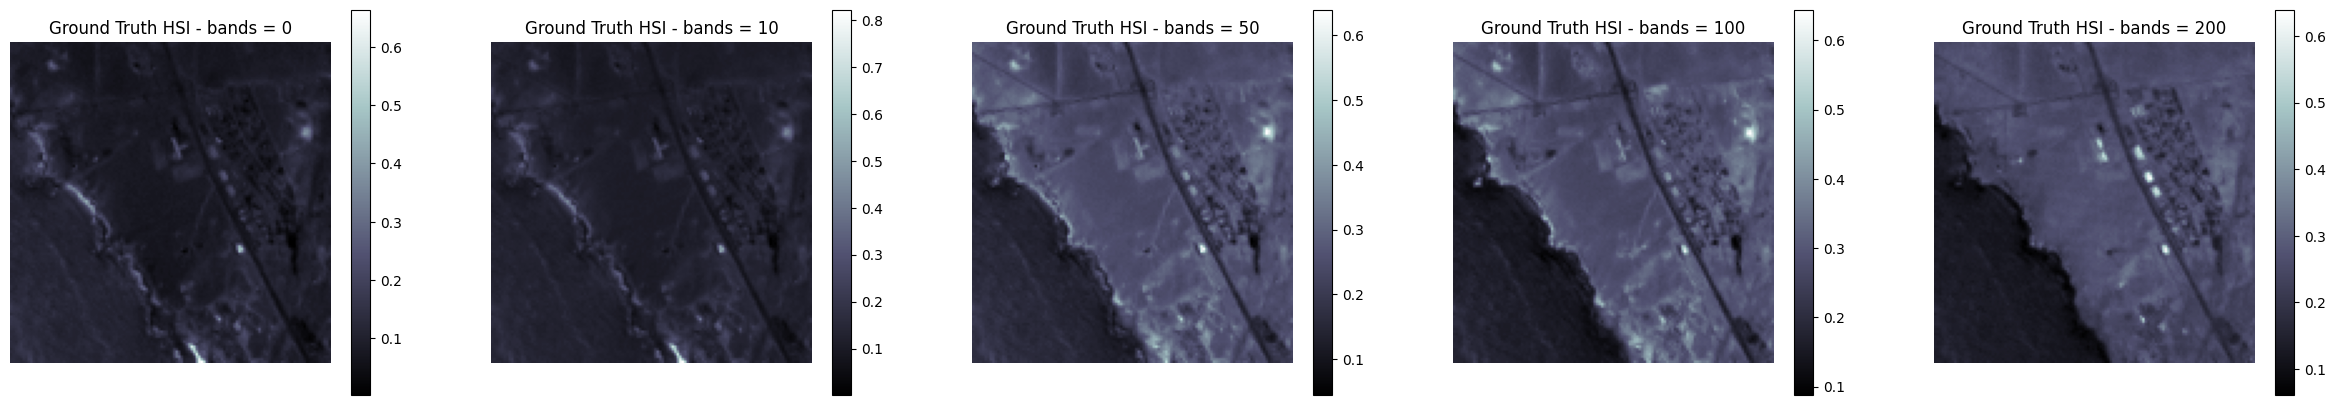

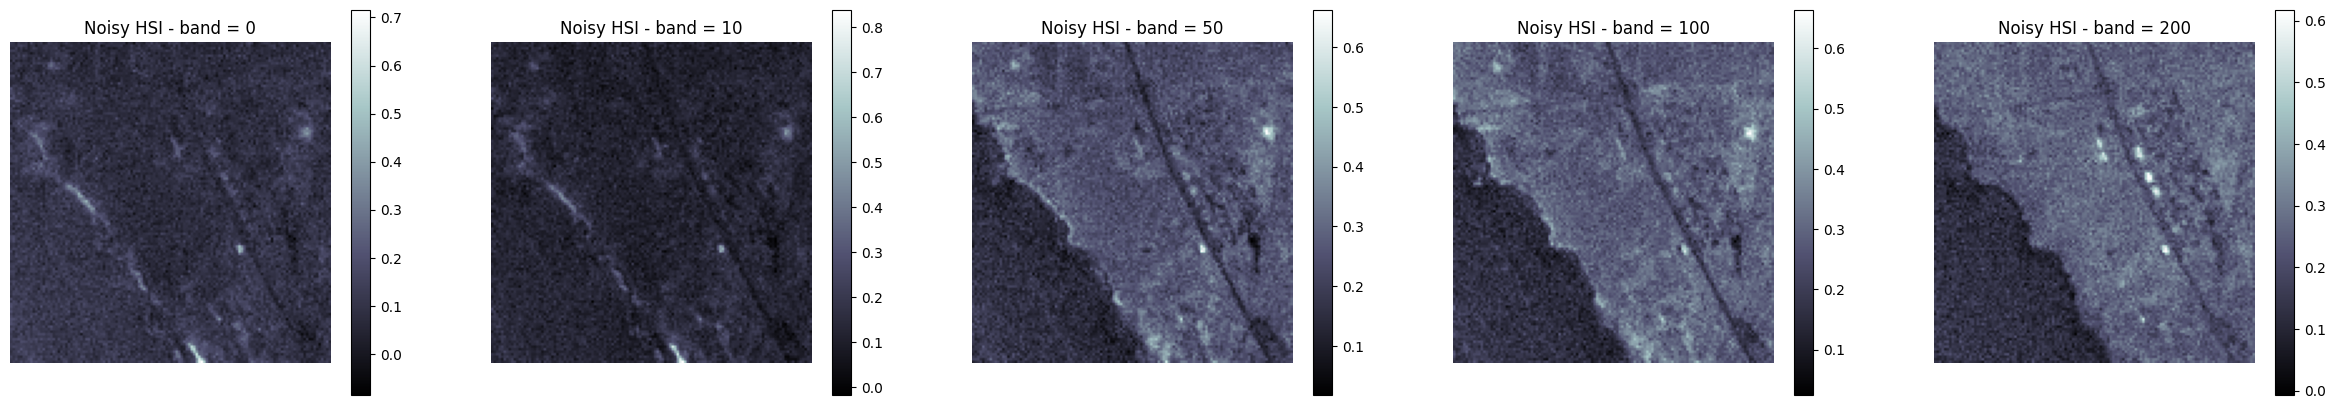

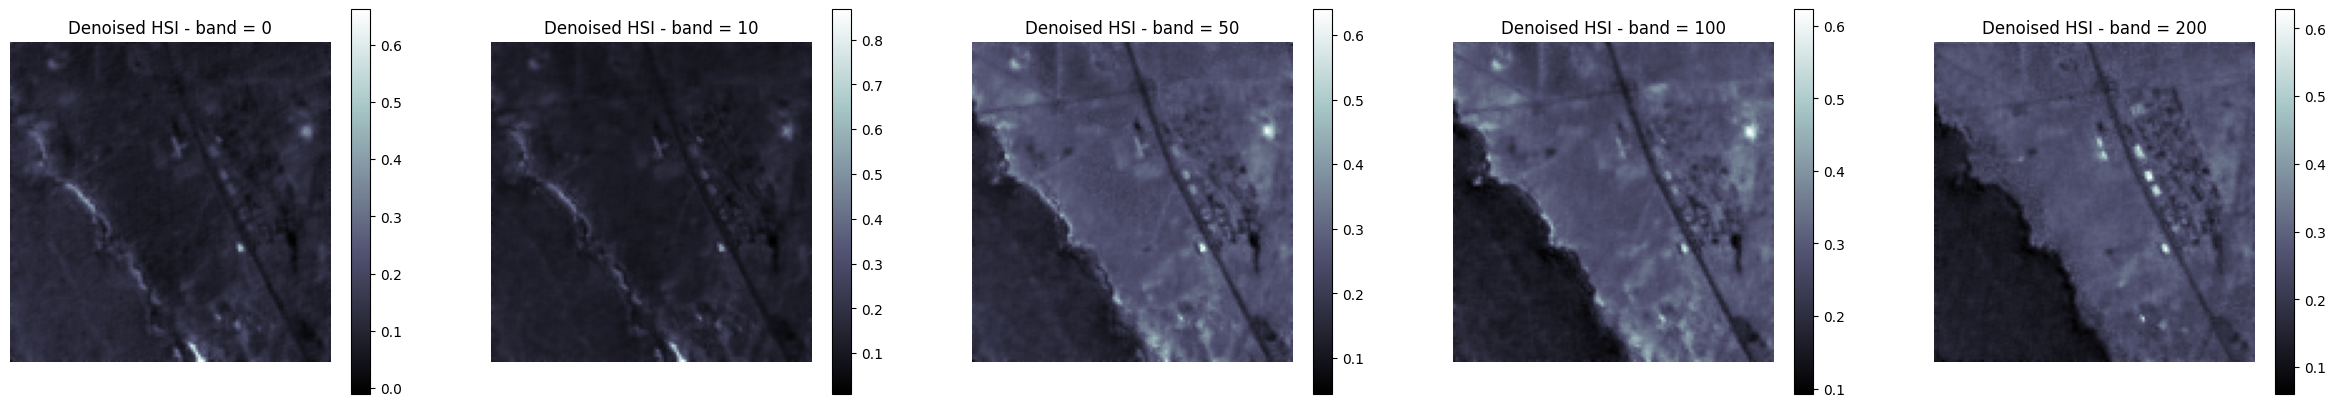

In [62]:


out = output_qrnn3D
cmap = 'bone'

band_index = [0, 10, 50, 100, 200]

plt.figure(figsize=(30, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(x[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Ground Truth HSI - bands = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(y[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy HSI - band = {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(band_index):
    plt.subplot(151+i)
    plt.imshow(out[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised HSI - band = {}'.format(idx))
    plt.axis('off')

plt.show()

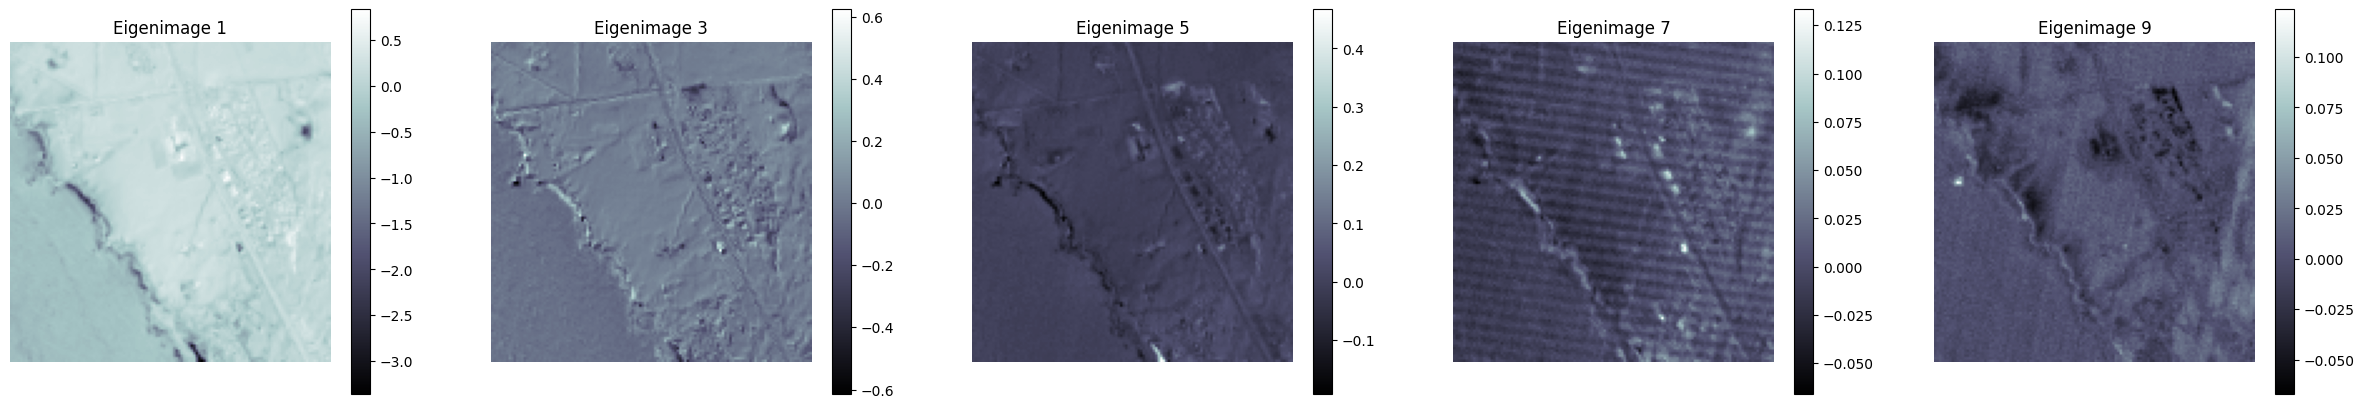

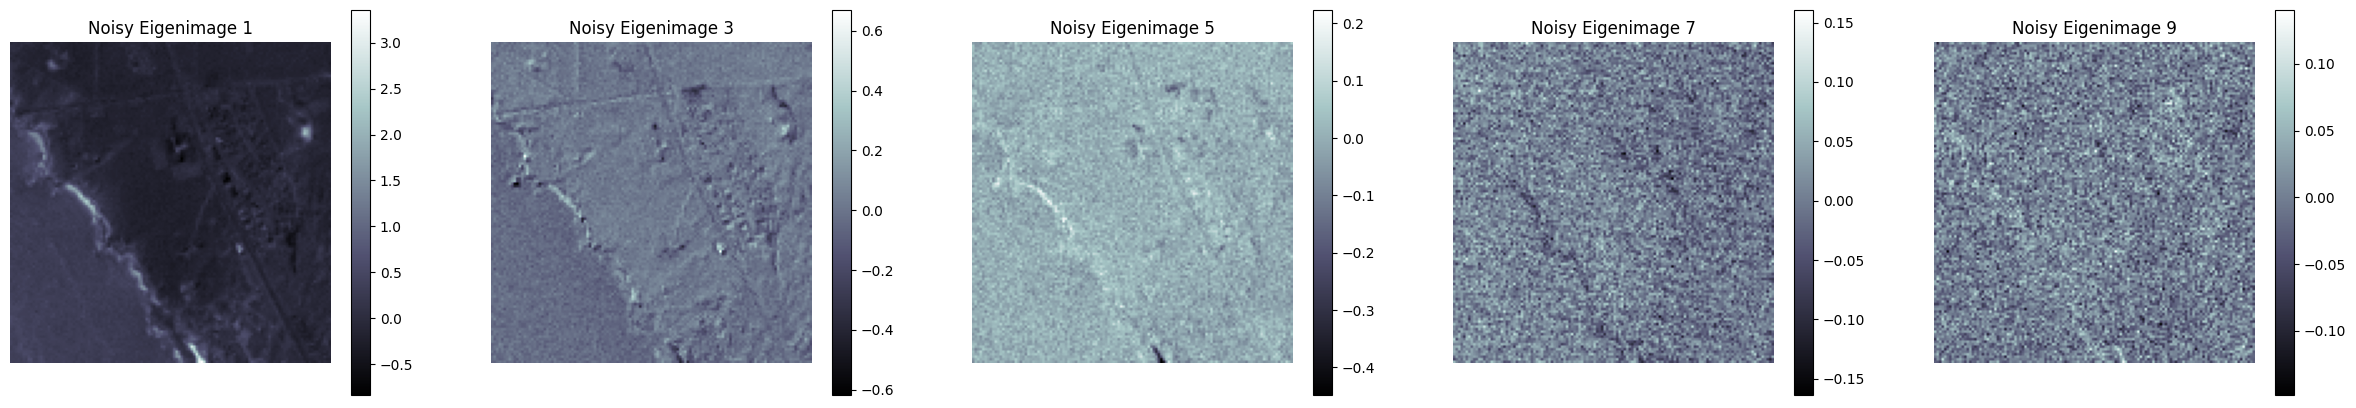

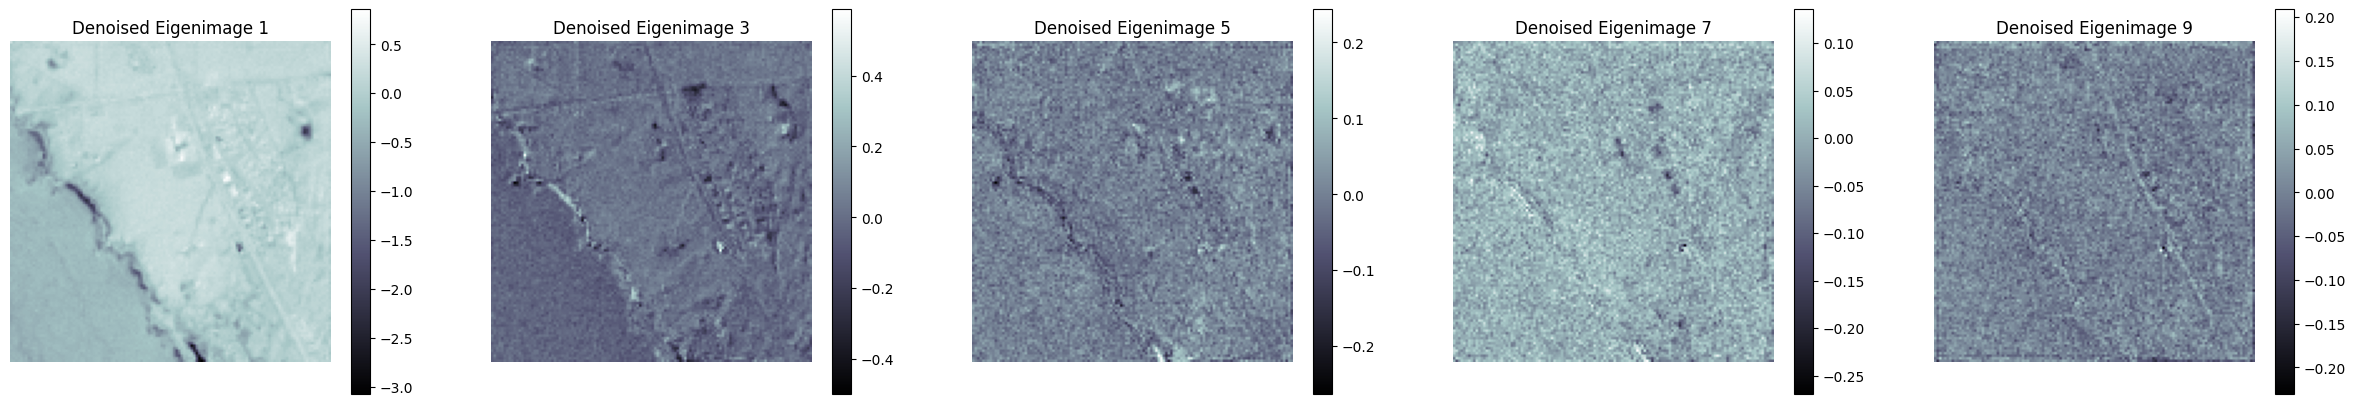

In [57]:
from datasets import get_eigenimages

z = get_eigenimages(x)
z_est = get_eigenimages(output_qrnn3D)
z_noisy = get_eigenimages(y)

eigen_index = [1,3,5,7,9]

cmap = 'bone'

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_noisy[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Noisy Eigenimage {}'.format(idx))
    plt.axis('off')

plt.figure(figsize=(30, 5))
for i, idx in enumerate(eigen_index):
    plt.subplot(151+i)
    plt.imshow(z_est[0, idx, ...].cpu().numpy(), cmap=cmap)
    plt.colorbar()
    plt.title('Denoised Eigenimage {}'.format(idx))
    plt.axis('off')

plt.show()